# Basic processing for a CML from the OpenMRG dataset with pycomlink

In [1]:
import opensense_data_downloader_and_transformer as oddt
import pycomlink as pycml

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

## Load data from the OpenMRG dataset
doi: https://doi.org/10.5194/essd-2022-221 


In [3]:
oddt.download_andersson_2022_OpenMRG(
    local_path="data/andersson_2022_OpenMRG/", print_output=True
)

Creating path data/andersson_2022_OpenMRG/
to data/andersson_2022_OpenMRG//OpenMRG.zip


('data/andersson_2022_OpenMRG/OpenMRG.zip',
 <http.client.HTTPMessage at 0x7f122009cac0>)

In [4]:
cmls = oddt.transform_andersson_2022_OpenMRG(
    fn="data/andersson_2022_OpenMRG/OpenMRG.zip",
    path_to_extract_to="data/andersson_2022_OpenMRG/",
)

## Basic CML processing for one sublink

Only one sublink is selected for fast execution on mybinder

In [5]:
cml = cmls.isel(sublink_id=0)

### Prepare data
Short gaps (<= 5min) in the time series will be interpolated  

TL (total path loss) is the transmitted signal level minus the received signal level and represents the total path loss along the CML

In [6]:
cml["tsl"] = cml.tsl.interpolate_na(dim="time", method="linear", max_gap="5min")
cml["rsl"] = cml.rsl.interpolate_na(dim="time", method="linear", max_gap="5min")
cml["tl"] = cml.tsl - cml.rsl

### Process data

Simple classification of rainy time stamps from [Schleiss and Berne (2010)](https://doi.org/10.1109/LGRS.2010.2043052)

In [7]:
cml["wet"] = cml.tl.rolling(time=520, center=True).std(skipna=False) > 0.8

Estimate a baseline during the rain events

In [8]:
cml["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=cml.tl,
    wet=cml.wet,
    n_average_last_dry=5,
)

Method to estiamte the effect of wet antenna attenuation from [Schleiss et al. 2013](https://doi.org/10.1109/LGRS.2012.2236074)

In [9]:
cml["waa"] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.tl,
    baseline=cml.baseline,
    wet=cml.wet,
    waa_max=2.2,
    delta_t=1,
    tau=15,
)

Derive attenuation caused by rain

In [10]:
cml["A"] = cml.tl - cml.baseline - cml.waa

Derive rain rates based on the `k-R`-relation

In [11]:
cml["rainfall_amount"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=cml.A,
    L_km=float(cml.length),
    f_GHz=cml.frequency,
)

## Plot results

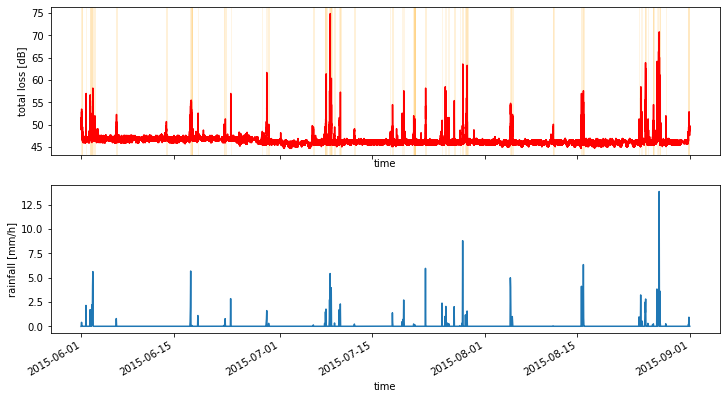

In [12]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 6), sharex=True)

cml.tl.plot.line(x="time", ax=ax[0], color="red")

# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet
wet_end = np.roll(cml.wet, 1) & ~cml.wet

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    ax[0].axvspan(
        cml.time.values[wet_start_i],
        cml.time.values[wet_end_i],
        color="orange",
        alpha=0.1,
    )


cml.rainfall_amount.resample(time="60min").mean().plot.line(x="time", ax=ax[1])

ax[0].set_title("")
ax[0].set_ylabel("total loss [dB]")
ax[1].set_title("")
ax[1].set_ylabel("rainfall [mm/h]");

## Simple validation

In [13]:
df = pd.read_csv("data/andersson_2022_OpenMRG/gauges/city/CityGauges-2015JJA.csv")
df = df.set_index(pd.to_datetime(df.Time_UTC, format="%Y-%m-%dT%H:%M:%SZ"))
meta = pd.read_csv("data/andersson_2022_OpenMRG/gauges/city/CityGauges-metadata.csv")

### Plot all CMLs and the one processed as well as reference rain gauges

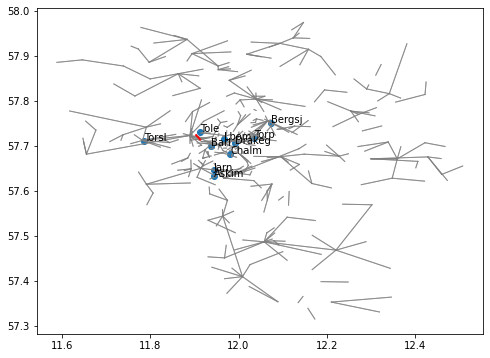

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(meta.Longitude_DecDeg, meta.Latitude_DecDeg)
for i, txt in enumerate(meta.Name.values):
    ax.annotate(txt, (meta.Longitude_DecDeg[i], meta.Latitude_DecDeg[i]))

for lon1, lat1, lon2, lat2 in zip(
    cmls.site_0_lon.values,
    cmls.site_0_lat.values,
    cmls.site_1_lon.values,
    cmls.site_1_lat.values,
):
    ax.plot([lon1, lon2], [lat1, lat2], "-", c="grey", alpha=0.7, lw=1)

ax.plot(
    [cml.site_0_lon.values, cml.site_1_lon.values],
    [cml.site_0_lat.values, cml.site_1_lat.values],
    "-",
    c="red",
    lw=2,
);

### Select a nearby gauge to compare the CML rainfall time series

resample to hourly rainfall sum

In [15]:
cml_hourly = cml.rainfall_amount.resample(time="60min").mean()
tole_hourly = df["Tole"].resample("60min").sum()

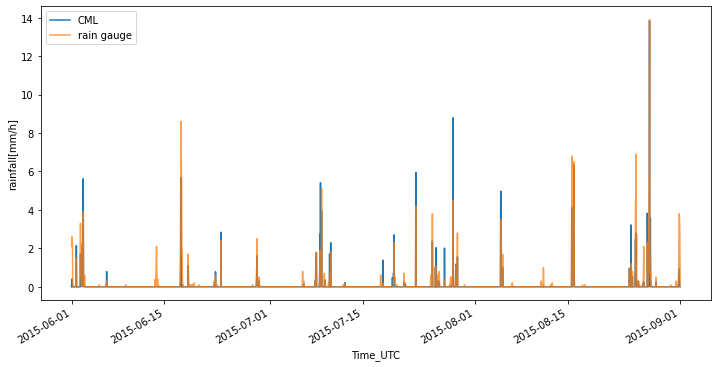

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
cml_hourly.plot.line(x="time", ax=ax, lw=1.5, label="CML")
tole_hourly.plot(alpha=0.75, label="rain gauge")
ax.set_ylabel("rainfall[mm/h]")
ax.legend()
ax.set_title("");

#### and a scatter plot of hourly rainfall values

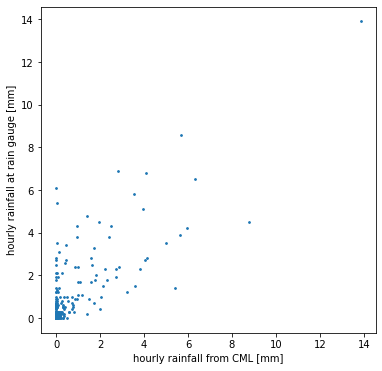

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    cml_hourly.sel(time=tole_hourly.index).values,
    tole_hourly.values,
    s=3,
)
ax.set_xlabel("hourly rainfall from CML [mm]")
ax.set_ylabel("hourly rainfall at rain gauge [mm]");